# **Classification**

Running experiments for the classification task of classifying wines as Good or Great wines.

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import zipfile

import nltk
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.help import upenn_tagset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import BisectingKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score

from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
# Opening zipfile and reading it to a dataframe
with zipfile.ZipFile('wine_reviews_clean.zip', 'r') as zipf:
    zipf.extractall('')

df = pd.read_csv('wine_reviews_clean.csv')

os.remove('wine_reviews_clean.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421017 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                421017 non-null  object 
 1   Variety             421017 non-null  object 
 2   Country             421017 non-null  object 
 3   Region              386109 non-null  object 
 4   Zone                253609 non-null  object 
 5   Attr_1              417986 non-null  object 
 6   Attr_2              76720 non-null   object 
 7   Winemaker_notes     95234 non-null   object 
 8   Review              93840 non-null   object 
 9   Alcohol_percentage  420952 non-null  float64
 10  Alcohol_vol         420952 non-null  float64
 11  Avg_rating          45970 non-null   float64
 12  N_ratings           45970 non-null   float64
 13  Price_Feature       419607 non-null  float64
 14  Year                418078 non-null  float64
dtypes: float64(6), object(9)
memory us

## **Feature Engineering**

### Categorical Variables

In [5]:
# Function to delete stopwords from the text
stop_words = set(stopwords.words('english'))
def strip_stopwords_lemmatize(text, lemmatize=True):
    try:
        # Convert text into lowercase
        text = text.lower()

        # Remove non alphanumerical characters and split the text into words
        words = re.findall(r'\b\w+\b', text)

        # Remove stopwords
        clean_words = [word for word in words if word not in stop_words]

        if lemmatize:
            # Lemmatize using WordNetLemmatizer
            WNLemma = WordNetLemmatizer()
            lemmatized_words = [WNLemma.lemmatize(word) for word in clean_words]
            lemmatized_text = ' '.join(lemmatized_words)
            return lemmatized_text
        else:
            # Cleaned text
            cleaned_text = ' '.join(clean_words)
            return cleaned_text
    except:
        # Case when there is no text to analyze
        return np.nan

In [6]:
# Applying the lemmatized approach for both the winemakers notes and the reviews
df2 = df.copy()

df2['Winemaker_notes'] = df['Winemaker_notes'].apply(strip_stopwords_lemmatize, lemmatize=True)
df2['Review'] = df['Review'].apply(strip_stopwords_lemmatize, lemmatize=True)

### Numerical Variables

In [3]:
# Function to get rid of outliers
def get_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data, nan_policy='omit'))
    outliers = np.where(z_scores > threshold, np.nan, 0)
    return outliers

In [8]:
# Clean the outliers
df3 = df2.copy()

# Get outliers and join dataframe
outliers = df3.select_dtypes('float64').apply(get_outliers, axis=0)
outliers_df = df3.join(outliers, rsuffix='_IsOutlier')
outliers_df.iloc[:, -6:].notna().sum()

# Eliminate this outliers
clean_df = outliers_df.dropna(subset=outliers_df.columns.tolist()[-6:])
clean_df = clean_df.drop(outliers_df.columns.tolist()[-6:], axis=1)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405906 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                405906 non-null  object 
 1   Variety             405906 non-null  object 
 2   Country             405906 non-null  object 
 3   Region              371395 non-null  object 
 4   Zone                241475 non-null  object 
 5   Attr_1              403100 non-null  object 
 6   Attr_2              68063 non-null   object 
 7   Winemaker_notes     89805 non-null   object 
 8   Review              84430 non-null   object 
 9   Alcohol_percentage  405841 non-null  float64
 10  Alcohol_vol         405841 non-null  float64
 11  Avg_rating          44313 non-null   float64
 12  N_ratings           44313 non-null   float64
 13  Price_Feature       405168 non-null  float64
 14  Year                403193 non-null  float64
dtypes: float64(6), object(9)
memory us

In [36]:
# Save dataframe to csv and then to zip
try:
    os.remove('wine_reviews_features.zip')
except:
    pass

clean_df.to_csv('wine_reviews_features.csv', index=False)

with zipfile.ZipFile('wine_reviews_features.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('wine_reviews_features.csv')

os.remove('wine_reviews_features.csv')

## **Experimentation**

The experimentation with the data will be carried out in the next format.
- Based on the variables.
- Based on the models used.

An will follow the next structure:
- Data selection according to the variables to test.
- Preprocessing the variables.
- Creating an Imbalanced Pipeline to balance classes.
- Training the model.
- Evaluate the model using classification report.

In [3]:
# Opening zipfile and reading it to a dataframe
with zipfile.ZipFile('wine_reviews_features.zip', 'r') as zipf:
    zipf.extractall('')

clean_df = pd.read_csv('wine_reviews_features.csv')

os.remove('wine_reviews_features.csv')

### Feature Engineering the Target Variable

As the first step to tackle this Classification problem, we need some understanding of the variables we are trying to predict. As said before, such variable is ***Avg_rating***, so an unsupervised approach to know how to partition the variable into classes might be helpful to determine future steps for classification.

In [12]:
# Fe columns
fe_cols = ['Winemaker_notes', 'Review', 'Avg_rating', 'Price_Feature', 'Year']

# Dataset for experimentation
fe = clean_df.dropna(subset=fe_cols)

# Creating ColumnTransformer to engineer the features into usable ones for a clustering model
preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
    ('Avg_rating', MinMaxScaler(), ['Avg_rating']),
    ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
    ('Year', MinMaxScaler(), ['Year'])
],
verbose=True,
remainder='passthrough')

# Creating Pipeline
fe_cluster = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', BisectingKMeans(n_clusters=3))
])

# Predicting the cluster for the whole dataset
fe['cluster'] = fe_cluster.fit_predict(fe[fe_cols])

# Describe the dataframe based on the created clusters
fe.groupby('cluster').describe()[['Avg_rating', 'Price_Feature']]

[ColumnTransformer]  (1 of 5) Processing Winemaker_notes, total=   3.5s
[ColumnTransformer] ........ (2 of 5) Processing Review, total=   3.6s
[ColumnTransformer] .... (3 of 5) Processing Avg_rating, total=   0.0s
[ColumnTransformer] . (4 of 5) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (5 of 5) Processing Year, total=   0.0s


Avg_rating                                              Price_Feature  \
             count      mean       std  min  25%  50%  75%  max         count   
cluster                                                                         
0           5920.0  4.513784  0.246611  3.6  4.3  4.5  4.7  5.0        5920.0   
1           4313.0  3.569418  0.224164  2.8  3.4  3.6  3.7  4.1        4313.0   
2           8232.0  4.020275  0.154567  3.7  3.9  4.0  4.1  4.4        8232.0   

                                                                  
              mean        std   min    25%    50%    75%     max  
cluster                                                           
0        72.911046  53.284243  7.99  35.99  55.99  94.99  284.99  
1        24.952439  14.497636  7.97  15.99  20.99  28.99  169.00  
2        26.495904  12.437923  7.97  17.99  22.99  31.99  159.00

With the ***BisectingKMeans*** approach we managed to identify three classes that can be viable for a classification problem, each one determined by each cluster found int he algorithm.
- Cluster 0: Classical wines with the highest rating.
- Cluster 1: Good wines with above average rating.
- Cluster 2: Acceptable wines with average rating.

This way we now have a strategy based on the data itself to partition the data in order to generate viable classes to continue with classification.

In [13]:
# Creating Pipeline for 2 clusters
fe_cluster = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', BisectingKMeans(n_clusters=2))
])

# Predicting the cluster for the whole dataset
fe['cluster'] = fe_cluster.fit_predict(fe[fe_cols])

# Describe the dataframe based on the created clusters
fe.groupby('cluster').describe()[['Avg_rating', 'Price_Feature']]

[ColumnTransformer]  (1 of 5) Processing Winemaker_notes, total=   3.6s
[ColumnTransformer] ........ (2 of 5) Processing Review, total=   2.9s
[ColumnTransformer] .... (3 of 5) Processing Avg_rating, total=   0.0s
[ColumnTransformer] . (4 of 5) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (5 of 5) Processing Year, total=   0.0s


Avg_rating                                              Price_Feature  \
             count      mean       std  min  25%  50%  75%  max         count   
cluster                                                                         
0           5975.0  4.511582  0.246692  3.6  4.3  4.5  4.7  5.0        5975.0   
1          12490.0  3.863467  0.279966  2.8  3.7  3.9  4.1  4.4       12490.0   

                                                                  
              mean        std   min    25%    50%    75%     max  
cluster                                                           
0        72.559136  53.179758  7.99  35.99  55.99  94.99  284.99  
1        25.926878  13.188041  7.97  16.99  22.99  29.99  169.00

In [16]:
# Creating a class to predict based on the unsupervised method
clean_df['Rating_3Class'] = np.where(pd.isna(clean_df['Avg_rating']), pd.NA,
                               np.where(clean_df['Avg_rating'] < 3.8, 'Acceptable',
                                        np.where(clean_df['Avg_rating'] < 4.4, 'Good', 'Classical')))

clean_df['Rating_2Class'] = np.where(pd.isna(clean_df['Avg_rating']), pd.NA,
                                     np.where(clean_df['Avg_rating'] < 4.5, 'Good', 'Classical'))

print(clean_df['Rating_3Class'].value_counts())
print()
print(clean_df['Rating_2Class'].value_counts())

Good          24047
Classical     10454
Acceptable     9812
Name: Rating_3Class, dtype: int64

Good         36703
Classical     7610
Name: Rating_2Class, dtype: int64


The next header cells containt he type of variables that are going to be tested in the cell contained between them, the last cell f each chunk contains conclusions and take-outs of each model.

### Text Variables

              precision    recall  f1-score   support

  Acceptable       0.32      0.45      0.37       719
   Classical       0.42      0.62      0.50       919
        Good       0.65      0.43      0.51      2102

    accuracy                           0.48      3740
   macro avg       0.46      0.50      0.46      3740
weighted avg       0.53      0.48      0.48      3740



<Figure size 800x500 with 0 Axes>

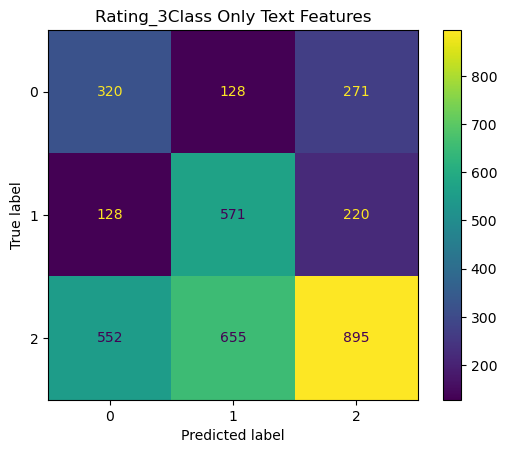

In [113]:
# Select the variables for the experiment at hand
exp1_var = ['Winemaker_notes', 'Review', 'Rating_3Class']

# Dataframe with the corresponding variables and dropping null values
exp1_df = clean_df.dropna(subset=exp1_var)

# Splitting classifiers and class
X = exp1_df[exp1_var].iloc[:, :-1]
y = exp1_df[exp1_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp1_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp1_pipeline = ImbalancedPipeline([
    ('preprocessing', exp1_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp1_pipeline.fit(X_train, y_train)
y_pred = exp1_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_3Class Only Text Features');

In [114]:
# Groupby Rating class
df = clean_df.dropna(subset=exp1_var[:-1])
df['Rating_3Class'] = exp1_pipeline.predict(df[exp1_var[:-1]])
df.groupby('Rating_3Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                         \
                count unique         top  freq mean  std  min  25%  50%  75%   
Rating_3Class                                                                  
Acceptable      10148    124  Chardonnay  1313  NaN  NaN  NaN  NaN  NaN  NaN   
Classical       18283    115  Pinot Noir  2758  NaN  NaN  NaN  NaN  NaN  NaN   
Good            15960    122  Pinot Noir  1725  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                  \
               max   count unique            top  freq mean  std  min  25%   
Rating_3Class                                                                
Acceptable     NaN   10148     24  United States  3172  NaN  NaN  NaN  NaN   
Classical      NaN   18283     25  United States  6217  NaN  NaN  NaN  NaN   
Good           NaN   15960     25  United States  6492  NaN  NaN  NaN  NaN   

                             Attr_1                                         \
               50%  75%  max  count unique       top   freq mean  std  min   
Rating_3Class                                                                
Acceptable     NaN  NaN  NaN  10070      8  Red Wine   4808  NaN  NaN  NaN   
Classical      NaN  NaN  NaN  18060      8  Red Wine  13858  NaN  NaN  NaN   
Good           NaN  NaN  NaN  15866      8  Red Wine  10787  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_3Class                                                          
Acceptable     NaN  NaN  NaN  NaN            10143.0    NaN NaN  NaN   
Classical      NaN  NaN  NaN  NaN            18265.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN            15950.0    NaN NaN  NaN   

                                                                   Avg_rating  \
                    mean       std  min   25%   50%      75%   max      count   
Rating_3Class                                                                   
Acceptable     10.166046  5.872176  0.0   8.5  13.0  14.0000  22.0     4172.0   
Classical       9.446552  6.655190  0.0   0.0  13.5  14.5000  22.0     5520.0   
Good           10.833162  5.755073  0.0  12.0  13.5  14.4275  24.9     9006.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_3Class                                                                
Acceptable       NaN NaN  NaN  3.650887  0.335971  2.8  3.5  3.6  3.8  5.0   
Classical        NaN NaN  NaN  4.470996  0.331454  2.8  4.4  4.5  4.7  5.0   
Good             NaN NaN  NaN  4.027360  0.204860  2.9  3.9  4.0  4.2  5.0   

              Price_Feature                                              \
                      count unique top freq       mean        std   min   
Rating_3Class                                                             
Acceptable          10140.0    NaN NaN  NaN  32.159143  25.786958  4.99   
Classical           18170.0    NaN NaN  NaN  84.598920  58.662050  5.99   
Good                15943.0    NaN NaN  NaN  39.159242  31.103625  7.97   

                                             
                 25%    50%     75%     max  
Rating_3Class                                
Acceptable     17.99  23.99   36.99  279.99  
Classical      41.97  67.99  114.99  285.97  
Good           19.99  28.99   46.99  284.99

              precision    recall  f1-score   support

   Classical       0.35      0.60      0.44       674
        Good       0.90      0.75      0.82      3066

    accuracy                           0.72      3740
   macro avg       0.62      0.68      0.63      3740
weighted avg       0.80      0.72      0.75      3740



<Figure size 800x500 with 0 Axes>

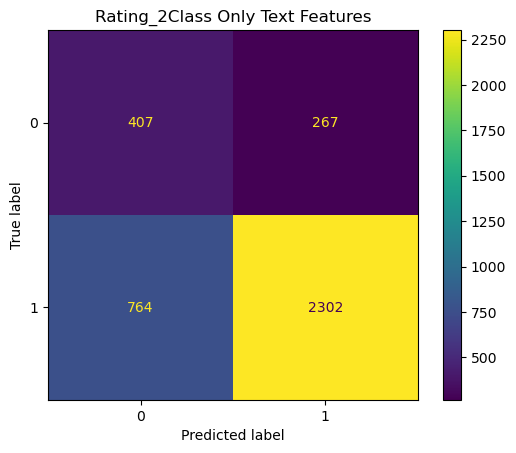

In [105]:
# Select the variables for the experiment at hand
exp1_var = ['Winemaker_notes', 'Review', 'Rating_2Class']

# Dataframe with the corresponding variables and dropping null values
exp1_df = clean_df.dropna(subset=exp1_var)

# Splitting classifiers and class
X = exp1_df[exp1_var].iloc[:, :-1]
y = exp1_df[exp1_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp1_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp1_pipeline = ImbalancedPipeline([
    ('preprocessing', exp1_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp1_pipeline.fit(X_train, y_train)
y_pred = exp1_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot()
plt.title('Rating_2Class Only Text Features')
plt.show();

In [112]:
# Groupby Rating class
df = clean_df.dropna(subset=exp1_var[:-1])
df['Rating_2Class'] = exp1_pipeline.predict(df[exp1_var[:-1]])
df.groupby('Rating_2Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                         \
                count unique         top  freq mean  std  min  25%  50%  75%   
Rating_2Class                                                                  
Classical       15701    109  Pinot Noir  2342  NaN  NaN  NaN  NaN  NaN  NaN   
Good            28690    134  Pinot Noir  2973  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                   \
               max   count unique            top   freq mean  std  min  25%   
Rating_2Class                                                                 
Classical      NaN   15701     25         France   5701  NaN  NaN  NaN  NaN   
Good           NaN   28690     27  United States  10869  NaN  NaN  NaN  NaN   

                             Attr_1                                         \
               50%  75%  max  count unique       top   freq mean  std  min   
Rating_2Class                                                                
Classical      NaN  NaN  NaN  15502      8  Red Wine  11708  NaN  NaN  NaN   
Good           NaN  NaN  NaN  28494      8  Red Wine  17745  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_2Class                                                          
Classical      NaN  NaN  NaN  NaN            15685.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN            28673.0    NaN NaN  NaN   

                                                                Avg_rating  \
                    mean       std  min   25%   50%   75%   max      count   
Rating_2Class                                                                
Classical       9.352273  6.664536  0.0   0.0  13.5  14.5  22.0     4738.0   
Good           10.523977  5.884333  0.0  11.5  13.5  14.2  24.9    13960.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_2Class                                                                
Classical        NaN NaN  NaN  4.478577  0.364250  2.8  4.3  4.5  4.7  5.0   
Good             NaN NaN  NaN  3.937128  0.319615  2.8  3.8  4.0  4.2  5.0   

              Price_Feature                                              \
                      count unique top freq       mean        std   min   
Rating_2Class                                                             
Classical           15596.0    NaN NaN  NaN  88.466248  59.852920  7.99   
Good                28657.0    NaN NaN  NaN  38.659046  31.763418  4.99   

                                             
                 25%    50%     75%     max  
Rating_2Class                                
Classical      43.99  69.99  119.99  285.97  
Good           19.99  27.99   45.99  284.99

Due to the presence of text data and its great length, the usage of other classifiers such as SVM and Decision Trees seems infeasible with this amount of data the available resources. So, from this point on we will only contemplate Naive Bayesian approaches for all experiments that cointain text data.

### Categorical Variables

              precision    recall  f1-score   support

  Acceptable       0.30      0.42      0.35      1742
   Classical       0.31      0.60      0.41      1948
        Good       0.59      0.26      0.36      4496

    accuracy                           0.37      8186
   macro avg       0.40      0.43      0.37      8186
weighted avg       0.46      0.37      0.37      8186



<Figure size 800x500 with 0 Axes>

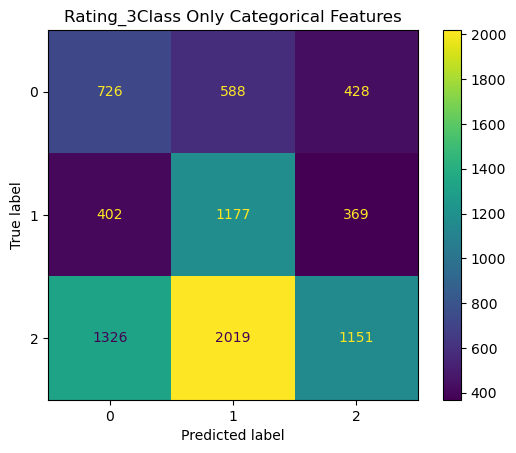

In [126]:
# Select the variables for the experiment at hand
exp2_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Rating_3Class']

# Dataframe with the corresponding variables and dropping null values
exp2_df = clean_df.dropna(subset=exp2_var)

# Splitting classifiers and class
X = exp2_df[exp2_var].iloc[:, :-1]
y = exp2_df[exp2_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp2_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1'])
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp2_pipeline = ImbalancedPipeline([
    ('preprocessing', exp2_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp2_pipeline.fit(X_train, y_train)
y_pred = exp2_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_3Class Only Categorical Features');

In [119]:
# Groupby Rating class
df = clean_df.dropna(subset=exp2_var[:-1])
df['Rating_3Class'] = exp2_pipeline.predict(df[exp2_var[:-1]])
df.groupby('Rating_3Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                      \
                count unique               top   freq mean  std  min  25%   
Rating_3Class                                                               
Acceptable     119349    111        Chardonnay  23484  NaN  NaN  NaN  NaN   
Classical      172087     82        Pinot Noir  45408  NaN  NaN  NaN  NaN   
Good            77800     81  Other Red Blends  11506  NaN  NaN  NaN  NaN   

                             Country                                         \
               50%  75%  max   count unique            top   freq mean  std   
Rating_3Class                                                                 
Acceptable     NaN  NaN  NaN  119349     14  United States  43156  NaN  NaN   
Classical      NaN  NaN  NaN  172087     14  United States  62486  NaN  NaN   
Good           NaN  NaN  NaN   77800     12  United States  49526  NaN  NaN   

                                        Attr_1                             \
               min  25%  50%  75%  max   count unique         top    freq   
Rating_3Class                                                               
Acceptable     NaN  NaN  NaN  NaN  NaN  119349      5  White Wine   68522   
Classical      NaN  NaN  NaN  NaN  NaN  172087      9    Red Wine  142120   
Good           NaN  NaN  NaN  NaN  NaN   77800      4    Red Wine   53454   

                                                 Alcohol_percentage         \
              mean  std  min  25%  50%  75%  max              count unique   
Rating_3Class                                                                
Acceptable     NaN  NaN  NaN  NaN  NaN  NaN  NaN           119349.0    NaN   
Classical      NaN  NaN  NaN  NaN  NaN  NaN  NaN           172087.0    NaN   
Good           NaN  NaN  NaN  NaN  NaN  NaN  NaN            77800.0    NaN   

                                                                       \
              top freq      mean       std  min  25%  50%   75%   max   
Rating_3Class                                                           
Acceptable    NaN  NaN  5.017592  6.574761  0.0  0.0  0.0  13.1  21.5   
Classical     NaN  NaN  4.894240  6.613273  0.0  0.0  0.0  13.5  22.0   
Good          NaN  NaN  5.533099  6.809071  0.0  0.0  0.0  13.5  24.9   

              Avg_rating                                                     \
                   count unique top freq      mean       std  min  25%  50%   
Rating_3Class                                                                 
Acceptable       12545.0    NaN NaN  NaN  3.944496  0.413176  2.8  3.7  3.9   
Classical        18792.0    NaN NaN  NaN  4.151229  0.421439  2.8  3.9  4.1   
Good              9593.0    NaN NaN  NaN  4.009434  0.377577  2.8  3.8  4.0   

                        Price_Feature                                        \
               75%  max         count unique top freq       mean        std   
Rating_3Class                                                                 
Acceptable     4.2  5.0      119255.0    NaN NaN  NaN  29.631825  27.664763   
Classical      4.4  5.0      171568.0    NaN NaN  NaN  51.948659  48.053563   
Good           4.2  5.0       77764.0    NaN NaN  NaN  28.728845  23.659470   

                                                 
               min    25%    50%    75%     max  
Rating_3Class                                    
Acceptable     0.0  13.99  20.99  34.99  285.97  
Classical      0.0  19.99  34.99  64.99  287.00  
Good           0.0  14.99  21.99  34.99  282.00

              precision    recall  f1-score   support

   Classical       0.24      0.64      0.35      1415
        Good       0.89      0.58      0.70      6771

    accuracy                           0.59      8186
   macro avg       0.56      0.61      0.53      8186
weighted avg       0.77      0.59      0.64      8186



<Figure size 800x500 with 0 Axes>

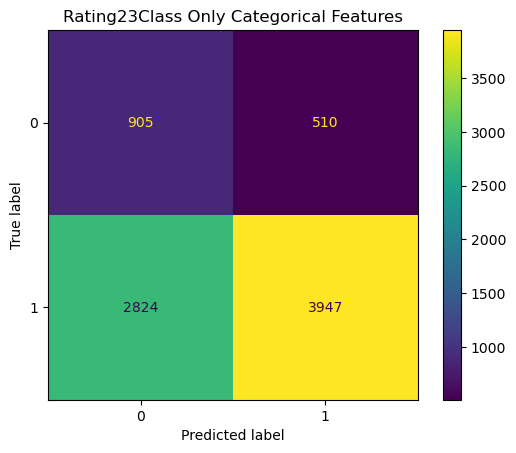

In [120]:
# Select the variables for the experiment at hand
exp2_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Rating_2Class']

# Dataframe with the corresponding variables and dropping null values
exp2_df = clean_df.dropna(subset=exp2_var)

# Splitting classifiers and class
X = exp2_df[exp2_var].iloc[:, :-1]
y = exp2_df[exp2_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp2_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1'])
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp2_pipeline = ImbalancedPipeline([
    ('preprocessing', exp2_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp2_pipeline.fit(X_train, y_train)
y_pred = exp2_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating23Class Only Categorical Features');

In [121]:
# Groupby Rating class
df = clean_df.dropna(subset=exp2_var[:-1])
df['Rating_2Class'] = exp2_pipeline.predict(df[exp2_var[:-1]])
df.groupby('Rating_2Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                          \
                count unique         top   freq mean  std  min  25%  50%  75%   
Rating_2Class                                                                   
Classical      180654     84  Pinot Noir  45941  NaN  NaN  NaN  NaN  NaN  NaN   
Good           188582    136  Chardonnay  24652  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                   \
               max   count unique            top   freq mean  std  min  25%   
Rating_2Class                                                                 
Classical      NaN  180654     14         France  63864  NaN  NaN  NaN  NaN   
Good           NaN  188582     15  United States  93211  NaN  NaN  NaN  NaN   

                              Attr_1                                          \
               50%  75%  max   count unique       top    freq mean  std  min   
Rating_2Class                                                                  
Classical      NaN  NaN  NaN  180654      9  Red Wine  145556  NaN  NaN  NaN   
Good           NaN  NaN  NaN  188582      8  Red Wine   99485  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_2Class                                                          
Classical      NaN  NaN  NaN  NaN           180654.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN           188582.0    NaN NaN  NaN   

                                                             Avg_rating  \
                   mean       std  min  25%  50%   75%   max      count   
Rating_2Class                                                             
Classical      4.814899  6.580558  0.0  0.0  0.0  13.5  22.0    18812.0   
Good           5.311874  6.701416  0.0  0.0  0.0  13.5  24.9    22118.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_2Class                                                                
Classical        NaN NaN  NaN  4.150595  0.426098  2.8  3.9  4.1  4.4  5.0   
Good             NaN NaN  NaN  3.973013  0.395390  2.8  3.7  4.0  4.2  5.0   

              Price_Feature                                                    \
                      count unique top freq       mean        std  min    25%   
Rating_2Class                                                                   
Classical          180123.0    NaN NaN  NaN  51.097249  47.861227  0.0  18.99   
Good               188464.0    NaN NaN  NaN  29.059933  25.319857  0.0  14.98   

                                     
                 50%    75%     max  
Rating_2Class                        
Classical      34.99  64.99  287.00  
Good           21.49  34.99  285.97

### Text and Categorical Variables

              precision    recall  f1-score   support

  Acceptable       0.29      0.45      0.35       662
   Classical       0.43      0.63      0.51       876
        Good       0.64      0.38      0.48      2001

    accuracy                           0.46      3539
   macro avg       0.45      0.49      0.45      3539
weighted avg       0.52      0.46      0.46      3539



<Figure size 800x500 with 0 Axes>

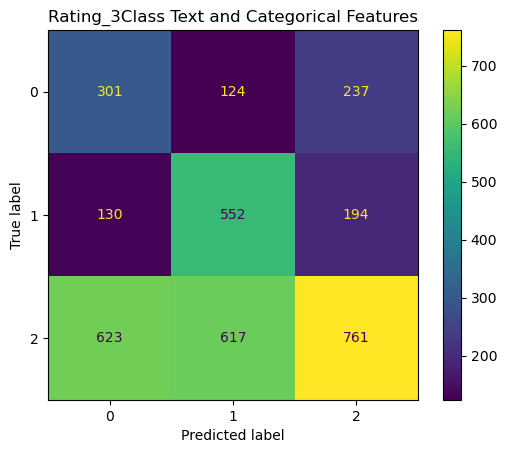

In [130]:
# Select the variables for the experiment at hand
exp3_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review', 'Rating_3Class']

# Dataframe with the corresponding variables and dropping null values
exp3_df = clean_df.dropna(subset=exp3_var)

# Splitting classifiers and class
X = exp3_df[exp3_var].iloc[:, :-1]
y = exp3_df[exp3_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp3_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp3_pipeline = ImbalancedPipeline([
    ('preprocessing', exp3_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp3_pipeline.fit(X_train, y_train)
y_pred = exp3_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_3Class Text and Categorical Features');

In [128]:
# Groupby Rating class
df = clean_df.dropna(subset=exp3_var[:-1])
df['Rating_3Class'] = exp3_pipeline.predict(df[exp3_var[:-1]])
df.groupby('Rating_3Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                         \
                count unique         top  freq mean  std  min  25%  50%  75%   
Rating_3Class                                                                  
Acceptable      10316    112  Chardonnay  1138  NaN  NaN  NaN  NaN  NaN  NaN   
Classical       17635     81  Pinot Noir  2964  NaN  NaN  NaN  NaN  NaN  NaN   
Good            13509    101  Pinot Noir  1538  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                  \
               max   count unique            top  freq mean  std  min  25%   
Rating_3Class                                                                
Acceptable     NaN   10316     14  United States  3022  NaN  NaN  NaN  NaN   
Classical      NaN   17635     14         France  7187  NaN  NaN  NaN  NaN   
Good           NaN   13509     13  United States  6794  NaN  NaN  NaN  NaN   

                             Attr_1                                           \
               50%  75%  max  count unique         top   freq mean  std  min   
Rating_3Class                                                                  
Acceptable     NaN  NaN  NaN  10316      6  White Wine   4993  NaN  NaN  NaN   
Classical      NaN  NaN  NaN  17635      8    Red Wine  13295  NaN  NaN  NaN   
Good           NaN  NaN  NaN  13509      4    Red Wine   9860  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_3Class                                                          
Acceptable     NaN  NaN  NaN  NaN            10316.0    NaN NaN  NaN   
Classical      NaN  NaN  NaN  NaN            17635.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN            13509.0    NaN NaN  NaN   

                                                                Avg_rating  \
                    mean       std  min   25%   50%   75%   max      count   
Rating_3Class                                                                
Acceptable     10.333154  5.727771  0.0  10.0  13.1  14.0  19.0     4379.0   
Classical       9.229474  6.647750  0.0   0.0  13.5  14.5  22.0     5567.0   
Good           11.013390  5.719613  0.0  12.5  13.6  14.5  24.9     7745.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_3Class                                                                
Acceptable       NaN NaN  NaN  3.709363  0.356963  2.8  3.5  3.7  3.9  5.0   
Classical        NaN NaN  NaN  4.440165  0.343927  2.8  4.3  4.5  4.7  5.0   
Good             NaN NaN  NaN  4.027721  0.208342  2.9  3.9  4.0  4.2  5.0   

              Price_Feature                                              \
                      count unique top freq       mean        std   min   
Rating_3Class                                                             
Acceptable          10315.0    NaN NaN  NaN  33.014685  26.253156  4.99   
Classical           17534.0    NaN NaN  NaN  86.030068  58.933767  7.97   
Good                13506.0    NaN NaN  NaN  39.433598  30.661187  7.99   

                                             
                 25%    50%     75%     max  
Rating_3Class                                
Acceptable     17.99  23.99   38.99  279.99  
Classical      41.99  68.99  115.99  285.97  
Good           19.99  29.99   47.99  284.99

              precision    recall  f1-score   support

   Classical       0.35      0.63      0.45       644
        Good       0.90      0.75      0.82      2895

    accuracy                           0.72      3539
   macro avg       0.63      0.69      0.63      3539
weighted avg       0.80      0.72      0.75      3539



<Figure size 800x500 with 0 Axes>

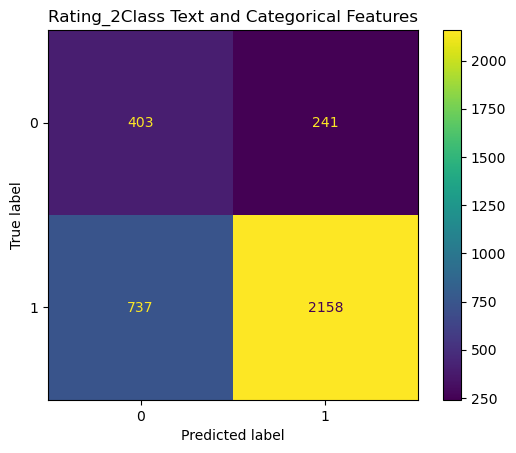

In [131]:
# Select the variables for the experiment at hand
exp3_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review', 'Rating_2Class']

# Dataframe with the corresponding variables and dropping null values
exp3_df = clean_df.dropna(subset=exp3_var)

# Splitting classifiers and class
X = exp3_df[exp3_var].iloc[:, :-1]
y = exp3_df[exp3_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp3_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp3_pipeline = ImbalancedPipeline([
    ('preprocessing', exp3_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp3_pipeline.fit(X_train, y_train)
y_pred = exp3_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_2Class Text and Categorical Features');

In [132]:
# Groupby Rating class
df = clean_df.dropna(subset=exp3_var[:-1])
df['Rating_2Class'] = exp3_pipeline.predict(df[exp3_var[:-1]])
df.groupby('Rating_2Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                        \
                count unique                  top  freq mean  std  min  25%   
Rating_2Class                                                                 
Classical       16028     78  Bordeaux Red Blends  2569  NaN  NaN  NaN  NaN   
Good            25432    124           Pinot Noir  2690  NaN  NaN  NaN  NaN   

                             Country                                         \
               50%  75%  max   count unique            top   freq mean  std   
Rating_2Class                                                                 
Classical      NaN  NaN  NaN   16028     14         France   7057  NaN  NaN   
Good           NaN  NaN  NaN   25432     14  United States  11065  NaN  NaN   

                                       Attr_1                               \
               min  25%  50%  75%  max  count unique       top   freq mean   
Rating_2Class                                                                
Classical      NaN  NaN  NaN  NaN  NaN  16028      8  Red Wine  11987  NaN   
Good           NaN  NaN  NaN  NaN  NaN  25432      7  Red Wine  15810  NaN   

                                            Alcohol_percentage             \
               std  min  25%  50%  75%  max              count unique top   
Rating_2Class                                                               
Classical      NaN  NaN  NaN  NaN  NaN  NaN            16028.0    NaN NaN   
Good           NaN  NaN  NaN  NaN  NaN  NaN            25432.0    NaN NaN   

                                                                      \
              freq       mean       std  min   25%   50%   75%   max   
Rating_2Class                                                          
Classical      NaN   9.144222  6.658578  0.0   0.0  13.4  14.5  22.0   
Good           NaN  10.678472  5.784932  0.0  12.0  13.5  14.3  24.9   

              Avg_rating                                                     \
                   count unique top freq      mean       std  min  25%  50%   
Rating_2Class                                                                 
Classical         5160.0    NaN NaN  NaN  4.421550  0.382229  2.8  4.2  4.5   
Good             12531.0    NaN NaN  NaN  3.937531  0.320517  2.8  3.8  4.0   

                        Price_Feature                                        \
               75%  max         count unique top freq       mean        std   
Rating_2Class                                                                 
Classical      4.7  5.0       15936.0    NaN NaN  NaN  88.195074  59.865196   
Good           4.2  5.0       25419.0    NaN NaN  NaN  38.400848  30.836228   

                                                   
                min    25%    50%     75%     max  
Rating_2Class                                      
Classical      7.97  42.99  69.99  119.99  285.97  
Good           4.99  19.99  27.99   45.99  284.99

### Text and Numerical Variables

              precision    recall  f1-score   support

  Acceptable       0.31      0.41      0.35       710
   Classical       0.42      0.66      0.51       900
        Good       0.63      0.41      0.50      2083

    accuracy                           0.47      3693
   macro avg       0.46      0.49      0.46      3693
weighted avg       0.52      0.47      0.48      3693



<Figure size 800x500 with 0 Axes>

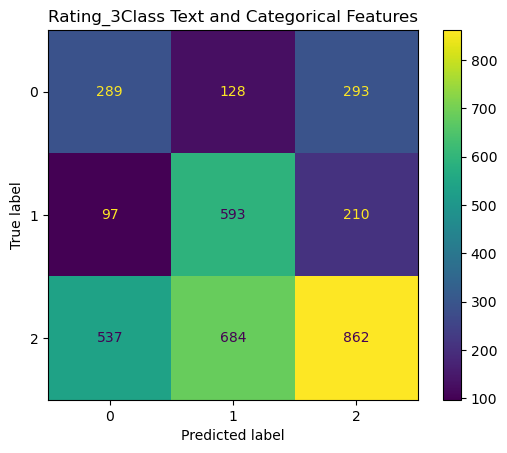

In [133]:
# Select the variables for the experiment at hand
exp4_var = ['Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year', 'Winemaker_notes', 'Review', 'Rating_3Class']

# Dataframe with the corresponding variables and dropping null values
exp4_df = clean_df.dropna(subset=exp4_var)

# Splitting classifiers and class
X = exp4_df[exp4_var].iloc[:, :-1]
y = exp4_df[exp4_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp4_preprocessor = ColumnTransformer([
    ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
    ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
    ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
    ('Year', MinMaxScaler(), ['Year']),
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp4_pipeline = ImbalancedPipeline([
    ('preprocessing', exp4_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp4_pipeline.fit(X_train, y_train)
y_pred = exp4_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_3Class Text and Categorical Features');

In [134]:
# Groupby Rating class
df = clean_df.dropna(subset=exp4_var[:-1])
df['Rating_3Class'] = exp4_pipeline.predict(df[exp4_var[:-1]])
df.groupby('Rating_3Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                         \
                count unique         top  freq mean  std  min  25%  50%  75%   
Rating_3Class                                                                  
Acceptable       9465    121  Chardonnay  1214  NaN  NaN  NaN  NaN  NaN  NaN   
Classical       18975    112  Pinot Noir  2912  NaN  NaN  NaN  NaN  NaN  NaN   
Good            15397    122  Pinot Noir  1620  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                  \
               max   count unique            top  freq mean  std  min  25%   
Rating_3Class                                                                
Acceptable     NaN    9465     23  United States  3028  NaN  NaN  NaN  NaN   
Classical      NaN   18975     24  United States  6629  NaN  NaN  NaN  NaN   
Good           NaN   15397     25  United States  6137  NaN  NaN  NaN  NaN   

                             Attr_1                                           \
               50%  75%  max  count unique         top   freq mean  std  min   
Rating_3Class                                                                  
Acceptable     NaN  NaN  NaN   9431      7  White Wine   4422  NaN  NaN  NaN   
Classical      NaN  NaN  NaN  18795      8    Red Wine  14488  NaN  NaN  NaN   
Good           NaN  NaN  NaN  15332      8    Red Wine  10476  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_3Class                                                          
Acceptable     NaN  NaN  NaN  NaN             9465.0    NaN NaN  NaN   
Classical      NaN  NaN  NaN  NaN            18975.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN            15397.0    NaN NaN  NaN   

                                                                Avg_rating  \
                    mean       std  min   25%   50%   75%   max      count   
Rating_3Class                                                                
Acceptable     10.238263  5.800788  0.0   9.5  13.0  14.0  20.1     4040.0   
Classical       9.408219  6.665128  0.0   0.0  13.5  14.5  21.5     5550.0   
Good           10.882271  5.711779  0.0  12.4  13.5  14.4  24.9     8875.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_3Class                                                                
Acceptable       NaN NaN  NaN  3.639752  0.321074  2.8  3.5  3.6  3.7  5.0   
Classical        NaN NaN  NaN  4.465982  0.331985  2.8  4.3  4.5  4.7  5.0   
Good             NaN NaN  NaN  4.024856  0.205890  2.8  3.9  4.0  4.2  5.0   

              Price_Feature                                              \
                      count unique top freq       mean        std   min   
Rating_3Class                                                             
Acceptable           9465.0    NaN NaN  NaN  29.969715  20.929039  6.99   
Classical           18975.0    NaN NaN  NaN  86.055461  58.612363  5.99   
Good                15397.0    NaN NaN  NaN  35.639485  24.735449  7.97   

                                             
                 25%    50%     75%     max  
Rating_3Class                                
Acceptable     16.99  22.99   35.99  269.99  
Classical      42.99  69.97  114.99  285.97  
Good           19.99  27.99   43.99  284.99

              precision    recall  f1-score   support

   Classical       0.35      0.63      0.45       644
        Good       0.90      0.75      0.82      2895

    accuracy                           0.72      3539
   macro avg       0.63      0.69      0.63      3539
weighted avg       0.80      0.72      0.75      3539



<Figure size 800x500 with 0 Axes>

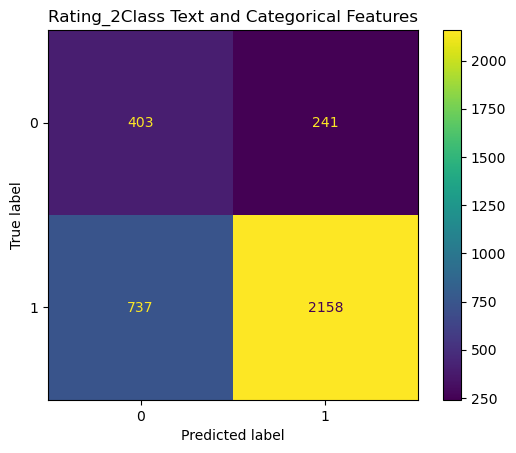

In [ ]:
# Select the variables for the experiment at hand
exp3_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review', 'Rating_2Class']

# Dataframe with the corresponding variables and dropping null values
exp3_df = clean_df.dropna(subset=exp3_var)

# Splitting classifiers and class
X = exp3_df[exp3_var].iloc[:, :-1]
y = exp3_df[exp3_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
exp3_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
exp3_pipeline = ImbalancedPipeline([
    ('preprocessing', exp3_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
exp3_pipeline.fit(X_train, y_train)
y_pred = exp3_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_2Class Text and Categorical Features');

In [ ]:
# Groupby Rating class
df = clean_df.dropna(subset=exp3_var[:-1])
df['Rating_2Class'] = exp3_pipeline.predict(df[exp3_var[:-1]])
df.groupby('Rating_2Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                        \
                count unique                  top  freq mean  std  min  25%   
Rating_2Class                                                                 
Classical       16028     78  Bordeaux Red Blends  2569  NaN  NaN  NaN  NaN   
Good            25432    124           Pinot Noir  2690  NaN  NaN  NaN  NaN   

                             Country                                         \
               50%  75%  max   count unique            top   freq mean  std   
Rating_2Class                                                                 
Classical      NaN  NaN  NaN   16028     14         France   7057  NaN  NaN   
Good           NaN  NaN  NaN   25432     14  United States  11065  NaN  NaN   

                                       Attr_1                               \
               min  25%  50%  75%  max  count unique       top   freq mean   
Rating_2Class                                                                
Classical      NaN  NaN  NaN  NaN  NaN  16028      8  Red Wine  11987  NaN   
Good           NaN  NaN  NaN  NaN  NaN  25432      7  Red Wine  15810  NaN   

                                            Alcohol_percentage             \
               std  min  25%  50%  75%  max              count unique top   
Rating_2Class                                                               
Classical      NaN  NaN  NaN  NaN  NaN  NaN            16028.0    NaN NaN   
Good           NaN  NaN  NaN  NaN  NaN  NaN            25432.0    NaN NaN   

                                                                      \
              freq       mean       std  min   25%   50%   75%   max   
Rating_2Class                                                          
Classical      NaN   9.144222  6.658578  0.0   0.0  13.4  14.5  22.0   
Good           NaN  10.678472  5.784932  0.0  12.0  13.5  14.3  24.9   

              Avg_rating                                                     \
                   count unique top freq      mean       std  min  25%  50%   
Rating_2Class                                                                 
Classical         5160.0    NaN NaN  NaN  4.421550  0.382229  2.8  4.2  4.5   
Good             12531.0    NaN NaN  NaN  3.937531  0.320517  2.8  3.8  4.0   

                        Price_Feature                                        \
               75%  max         count unique top freq       mean        std   
Rating_2Class                                                                 
Classical      4.7  5.0       15936.0    NaN NaN  NaN  88.195074  59.865196   
Good           4.2  5.0       25419.0    NaN NaN  NaN  38.400848  30.836228   

                                                   
                min    25%    50%     75%     max  
Rating_2Class                                      
Classical      7.97  42.99  69.99  119.99  285.97  
Good           4.99  19.99  27.99   45.99  284.99

### Categorical and Numerical Variables

### Text, Categorical, and Numerical Variables